In [75]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os

In [76]:
'''
    USER INPUT
'''

DO_SAVE = True
test_name = 'test'
save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join('logs', test_name)

In [77]:
if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [78]:
def parse_log_file(log_file_path):

    # Regular expressions to capture the timestamp and data from each log message type AND
    # Initialize empty lists for storing the data

    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    # Idle time
    idle_time_regex = re.compile(timestamp_regex + r" .*Idle time=(\d+\.?\d*)ms process input time=(\d+\.?\d*)ms for layer=(\d+)")
    idle_time_data = []
    
    # Layer execution
    execute_layer_ts_regex = re.compile(timestamp_regex + r" .*Executed layer=(\d+) ([^;]*)\n")
    execute_layers_regex = re.compile(timestamp_regex + r" .*Executed to ([^;]*) layer=(\d+) in time=(\d+\.?\d*)ms")
    execute_layer_ts_data = []
    execute_layers_data = []

    # transmit routines
    send_data_regex = re.compile(timestamp_regex + r" .*Sent data ACKOWLEDGED for layer=(\d+) time=(\d+\.?\d*)ms bytes=(\d+) serialize time=(\d+\.?\d*)ms encode time=(\d+\.?\d*)ms")
    prep_out_regex = re.compile(timestamp_regex + r" .*layer=(\d+) time=(\d+\.?\d*)ms")
    send_data_data = []
    prep_out_data = []
    
    # receive routines
    received_layer_regex = re.compile(timestamp_regex + r" .*Received layer=(\d+): receive time=(\d+\.?\d*)ms, deserialize time=(\d+\.?\d*)ms bytes=(\d+)")
    received_layer_data = []

    # total runtime
    total_runtime_regex = re.compile(timestamp_regex + r" .*Total runtime=(\d+\.?\d*)s")

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            idle_time_match = idle_time_regex.search(line)
            if idle_time_match:
                idle_time_data.append({
                    'timestamp': idle_time_match.group(1),
                    'idle_time': float(idle_time_match.group(2)),
                    'process_input': float(idle_time_match.group(3)),
                    'layer': int(idle_time_match.group(4))
                })
                continue
            
            # Check for executed layer timestamps 
            execute_layer_ts_match = execute_layer_ts_regex.search(line)
            if execute_layer_ts_match:
                execute_layer_ts_data.append({
                    'timestamp': execute_layer_ts_match.group(1),
                    'layer': int(execute_layer_ts_match.group(2)),
                    'layer_name': str(execute_layer_ts_match.group(3))
                })
                continue

            # Check for executed layer messages (for layer blocks  vs individual)
            execute_layers_match = execute_layers_regex.search(line)
            if execute_layers_match:
                execute_layers_data.append({
                    'timestamp': execute_layers_match.group(1),
                    'layer_name': str(execute_layers_match.group(2)),
                    'layer': int(execute_layers_match.group(3)),
                    'execute_time': float(execute_layers_match.group(4))
                })
                continue

            # Check for sent data ACKOWLEDGED messages
            send_data_match = send_data_regex.search(line)
            if send_data_match:
                send_data_data.append({
                    'timestamp': send_data_match.group(1),
                    'layer': int(send_data_match.group(2)),
                    'send_time': float(send_data_match.group(3)),
                    'bytes_tx': int(send_data_match.group(4)),
                    'serialize_time': float(send_data_match.group(5)),
                    'encode_time_tx': float(send_data_match.group(6))
                })
                continue
            
            # Prep out data
            prep_out_match = prep_out_regex.search(line)
            if prep_out_match:
                prep_out_data.append({
                    'timestamp': prep_out_match.group(1),
                    'layer': int(prep_out_match.group(2)),
                    'prep_time': float(prep_out_match.group(3))
                })

            # Check for received layer messages
            received_layer_match = received_layer_regex.search(line)
            if received_layer_match:
                received_layer_data.append({
                    'timestamp': received_layer_match.group(1),
                    'layer': int(received_layer_match.group(2)),
                    'receive_time': float(received_layer_match.group(3)),
                    'deserialize_time': float(received_layer_match.group(4)),
                    'bytes_rx': int(received_layer_match.group(5))
                })
            
            total_runtime_match = total_runtime_regex.search(line)
            if total_runtime_match:
                total_runtime = float(total_runtime_match.group(2))


    # Convert the lists into pandas DataFrames
    idle_time_df = pd.DataFrame(idle_time_data)
    execute_layer_ts_df = pd.DataFrame(execute_layer_ts_data)
    execute_layers_df = pd.DataFrame(execute_layers_data)
    send_data_df = pd.DataFrame(send_data_data)
    prep_out_df = pd.DataFrame(prep_out_data)
    received_layer_df = pd.DataFrame(received_layer_data)
    

    # Print DataFrames to verify
    '''
    print("Idle Time DataFrame:")
    print(idle_time_df)
    print("\nExecute Layers DataFrame:")
    print(execute_layers_df)
    print("\nSend Data DataFrame:")
    print(send_data_df)
    print("\nReceived Layer DataFrame:")
    print(received_layer_df)
    '''

    return idle_time_df, execute_layer_ts_df, execute_layers_df, send_data_df, prep_out_df, received_layer_df, total_runtime


In [79]:
def parse_debug_log_file(log_file_path):
    ''' 
        Parses extra outputs from split manager when the debug flag is enabled.
        To get these extra outputs, a second run is required.
        Extra outputs are: FLOPS, num_parameters
        It is assumed that if the debug flag is enabled the computation will be slowed and delay results will be adversely effected 
        THEREFORE, a second run is required. 
    '''
    # Regular expressions to capture the timestamp and data from each log message type
    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    #2024-09-21 18:15:00,763 - source.core.split_manager - DEBUG - FLOPS for conv1 layer=1 FLOPS=589824.0 parameters=576.0
    flops_regex = re.compile(timestamp_regex + r" .*FLOPS for ([^;]*) layer=(\d+) FLOPS=(\d+\.?\d*) parameters=(\d+\.?\d*)")

    # Initialize empty lists for storing the data
    flops_data = []

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            flops_match = flops_regex.search(line)
            if flops_match:
                flops_data.append({
                    'timestamp': flops_match.group(1),
                    'layer_name': str(flops_match.group(2)),
                    'layer': int(flops_match.group(3)), 
                    'FLOPS': float(flops_match.group(4)),
                    'parameters': float(flops_match.group(5))
                })
                continue

    # Convert the lists into pandas DataFrames
    flops_df = pd.DataFrame(flops_data)

    # Save DataFrames to CSV (optional)
    '''
    idle_time_df.to_csv('flops_df.csv', index=False)
    '''

    # Print DataFrames to verify
    #print("FLOPS DataFrame:")
    #print(flops_df)

    return flops_df


In [80]:
'''
    Get data for each log file
'''

total_runtime = []
for i in range(4):
    #print(f'\n\n Network Node {i}')
    node_log_file_path= os.path.join(log_file_path,f'node{i}_resnet18.log')
    node_log_debug_path = os.path.join(log_file_path,f'node{i}_resnet18_debug.log')
    idle_time_df_tmp, execute_layer_ts_df_tmp, execute_layers_df_tmp, send_data_df_tmp, prep_out_tmp, received_layer_df_tmp, total_runtime_tmp = parse_log_file(node_log_file_path)
    flops_df_tmp = parse_debug_log_file(node_log_debug_path)

    total_runtime.append(total_runtime_tmp)

    idle_time_df_tmp['node'] = i
    execute_layer_ts_df_tmp['node'] = i
    execute_layers_df_tmp['node'] = i
    send_data_df_tmp['node'] = i
    prep_out_tmp['node'] = i
    received_layer_df_tmp['node'] = i
    flops_df_tmp['node'] = i

    if i ==0:
        idle_time_df = idle_time_df_tmp
        execute_layer_ts_df = execute_layer_ts_df_tmp
        execute_layers_df = execute_layers_df_tmp
        send_data_df = send_data_df_tmp
        prep_out_df = prep_out_tmp
        received_layer_df = received_layer_df_tmp
        flops_df = flops_df_tmp
    else:
        idle_time_df = pd.concat([idle_time_df, idle_time_df_tmp])
        execute_layer_ts_df = pd.concat([execute_layer_ts_df, execute_layer_ts_df_tmp])
        execute_layers_df = pd.concat([execute_layers_df_tmp, execute_layers_df])
        send_data_df = pd.concat([send_data_df_tmp, send_data_df])
        prep_out_df = pd.concat([prep_out_df, prep_out_tmp])
        received_layer_df = pd.concat([received_layer_df_tmp, received_layer_df])
        flops_df = pd.concat([flops_df, flops_df_tmp])

# convert timestamp strings to datetime
time_format_str = '%Y-%m-%d %H:%M:%S,%f'
idle_time_df['timestamp'] = pd.to_datetime(idle_time_df['timestamp'], format=time_format_str)
execute_layer_ts_df['timestamp'] = pd.to_datetime(execute_layer_ts_df['timestamp'], format=time_format_str)
execute_layers_df['timestamp'] = pd.to_datetime(execute_layers_df['timestamp'], format=time_format_str)
send_data_df['timestamp'] = pd.to_datetime(send_data_df['timestamp'],format=time_format_str)
prep_out_df['timestamp'] = pd.to_datetime(prep_out_df['timestamp'],format=time_format_str)
received_layer_df['timestamp'] = pd.to_datetime(received_layer_df['timestamp'], format=time_format_str)
flops_df['timestamp'] = pd.to_datetime(flops_df['timestamp'], format=time_format_str)

# zero to 1st entry across all messages TODO: use starting model debug message as reference 
start_time = min(pd.concat([idle_time_df['timestamp'], execute_layer_ts_df['timestamp'],  execute_layers_df['timestamp'], send_data_df['timestamp'], received_layer_df['timestamp']]))
idle_time_df['timestamp'] = (idle_time_df['timestamp'] -start_time).dt.total_seconds()
execute_layer_ts_df['timestamp'] = (execute_layer_ts_df['timestamp'] - start_time).dt.total_seconds()
execute_layers_df['timestamp'] = (execute_layers_df['timestamp']-start_time).dt.total_seconds()
send_data_df['timestamp'] = (send_data_df['timestamp']-start_time).dt.total_seconds()
prep_out_df['timestamp'] = (prep_out_df['timestamp']-start_time).dt.total_seconds()
received_layer_df['timestamp'] = (received_layer_df['timestamp']-start_time).dt.total_seconds()

idle_time_df.sort_values(by=['timestamp'])
execute_layer_ts_df.sort_values(by=['timestamp'])
execute_layers_df.sort_values(by=['timestamp'])
send_data_df.sort_values(by=['timestamp'])
prep_out_df.sort_values(by='timestamp')
received_layer_df.sort_values(by=['timestamp'])

# Save DataFrames to CSV (optional)
idle_time_df.to_csv(os.path.join(log_file_path,'idle_time.csv'), index=False)
execute_layer_ts_df.to_csv(os.path.join(log_file_path,'execute_layer_ts.csv'), index=False)
execute_layers_df.to_csv(os.path.join(log_file_path,'execute_layer.csv'), index=False)
send_data_df.to_csv(os.path.join(log_file_path,'send_data.csv'), index=False)
prep_out_df.to_csv(os.path.join(log_file_path,'prep_out.csv'), index=False)
received_layer_df.to_csv(os.path.join(log_file_path,'received_layer.csv'), index=False)



In [81]:
idle_time_df_tmp, execute_layer_ts_df_tmp, execute_layers_df_tmp, send_data_df_tmp, prep_out_tmp, received_layer_df_tmp, total_runtime_tmp = parse_log_file(node_log_file_path)


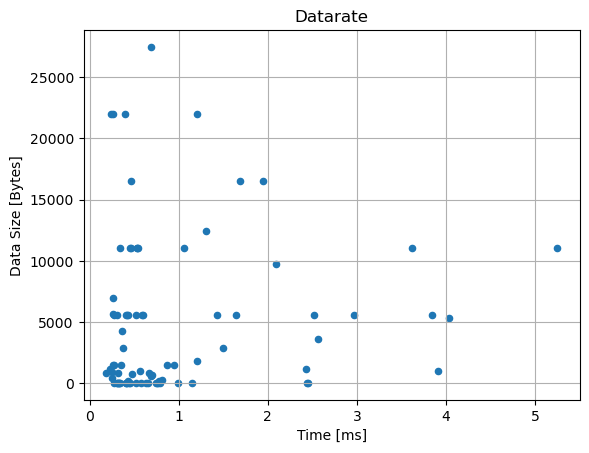

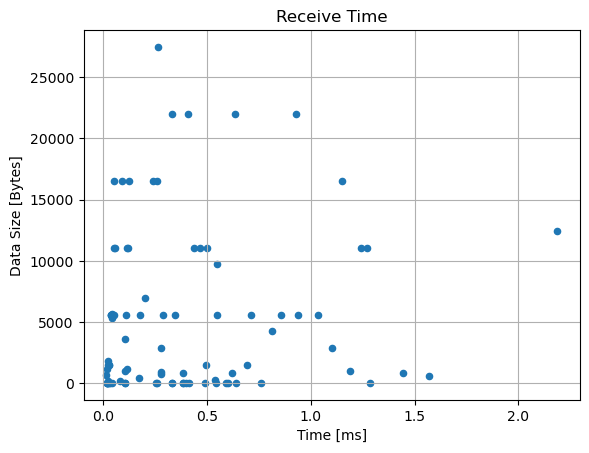

In [82]:
'''
    Make scatter plots for TX and RX
'''

ax_send = send_data_df.plot.scatter(x='send_time', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = received_layer_df.plot.scatter(x='receive_time', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [83]:
'''
    Breakdown of total time spent in different states
'''
for i in range(4):
    total_idle_time = sum(idle_time_df['idle_time'][idle_time_df['node'] == i]) # ms 
    total_process_time = sum(idle_time_df['process_input'][idle_time_df['node'] == i]) # ms
    total_exec_time = sum(execute_layers_df['execute_time'][execute_layers_df['node'] == i]) # ms
    total_tx_time = sum(send_data_df['send_time'][send_data_df['node'] == i]) # ms
    total_prep_time = sum(prep_out_df['prep_time'][prep_out_df['node'] == i]) # ms
    total_rx_time = sum(received_layer_df['receive_time'][received_layer_df['node'] == i] + received_layer_df['deserialize_time'][received_layer_df['node'] == i] )  # ms
    timed_total_time = sum([total_idle_time, total_exec_time, total_prep_time])

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 0.36255169997457415s
            States  Time [ms]  Percent [%]
0             IDLE    75.9364    20.944985
1  CHECK IN (IDLE)    48.0102    13.242304
2        TX (IDLE)    19.4272     0.025584
3        RX (IDLE)    19.8086    26.085777
4        EXECUTING   172.0642    47.459218
5             PREP    87.8751    24.237950
6            Total   335.8757    92.642153

Node 1
Run time 0.4123337999917567s
            States  Time [ms]  Percent [%]
0             IDLE    84.8954    20.588998
1  CHECK IN (IDLE)    40.1243     9.731024
2        TX (IDLE)    16.0079     0.018856
3        RX (IDLE)    13.0548    15.377511
4        EXECUTING   211.1057    51.197767
5             PREP    89.9411    21.812692
6            Total   385.9422    93.599457

Node 2
Run time 0.37187380000250414s
            States  Time [ms]  Percent [%]
0             IDLE    45.8847    12.338783
1  CHECK IN (IDLE)    36.7751     9.889134
2        TX (IDLE)    16.0163     0.034906
3        RX (IDLE)    16.584

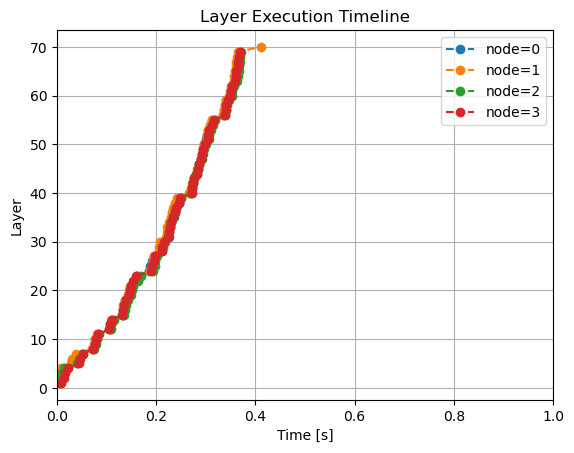

In [84]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(execute_layer_ts_df[execute_layer_ts_df['node'] == i]['timestamp'] ,execute_layer_ts_df[execute_layer_ts_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [s]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,1)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



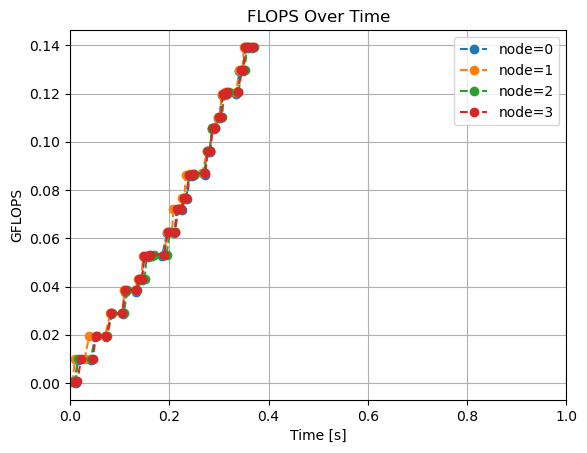

In [85]:
merged_layer_df = pd.merge(execute_layer_ts_df, flops_df, on=['layer_name', 'node', 'layer'], how='right')
merged_layer_df.sort_values(by=['timestamp_x'])

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):

    tmp_merged_layer_df = merged_layer_df[merged_layer_df['node'] == i]
    cum_bytes = np.cumsum(tmp_merged_layer_df['FLOPS'].to_numpy())
    plt.plot(tmp_merged_layer_df['timestamp_x'] ,cum_bytes/1e9, '--o')
    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, 1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


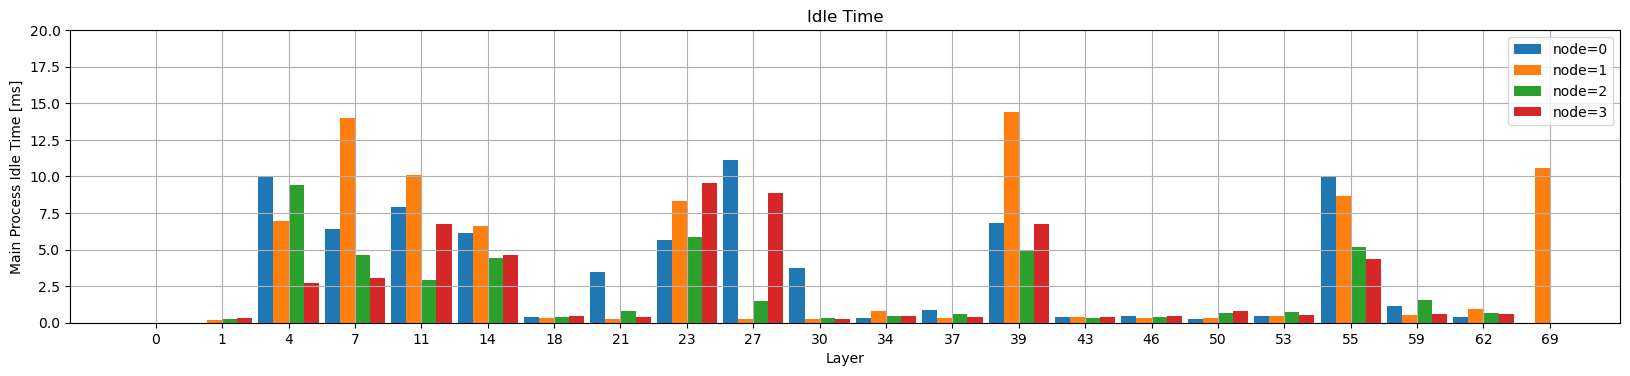

In [91]:
'''
    Look at idling durations
    - idle time includes time spent receiving
    - idle time does not include time spent sending 
    - idle time does not include time spent doing split layer computation 

    # TODO: put bars next to one another 
'''

width = 4
uniq_layers = np.unique(idle_time_df['layer'])  # map layer number to bar index
num_layers= len(uniq_layers)
layer_array = np.arange(num_layers)

plt.figure(figsize=(20,3.8))
plt.grid()
legend_strs = []
for i in range(4):
    # map arrays to indexes on plot
    index_map = np.isin(uniq_layers, idle_time_df[idle_time_df['node'] == i]['layer']).nonzero()[0]
    plt.bar(  index_map*17.6+width*(i-1.5) ,idle_time_df[idle_time_df['node'] == i]['idle_time'], width)
    legend_strs += [f'node={i}']
plt.title('Idle Time')
plt.xlabel('Layer')
plt.ylabel('Main Process Idle Time [ms]')
plt.legend(legend_strs)


_ = plt.xticks(layer_array*17.6, uniq_layers)
plt.ylim(0, 20)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'idle_time.jpg'))


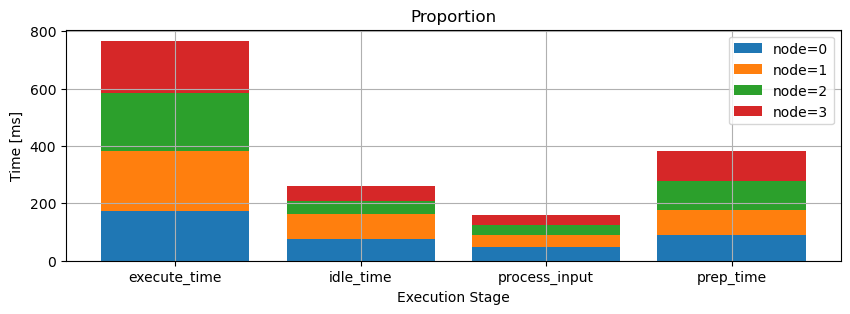

In [87]:
'''
    WIP Compare durations from different states 

    # TODO: put bars next to one another 

'''

# TODO: make master df the end all be all data structure 
# pre process to put these into one row per block: received_layer_df, send_data_df
master_df =execute_layers_df
for a_df in [idle_time_df, prep_out_df]:
    master_df = pd.merge(master_df, a_df, on=['node', 'layer'], how='outer')
master_df = master_df.sort_values(by='timestamp_x')
master_df.to_csv(os.path.join(log_file_path,'block_timing.csv'), index=False)

stages = ["execute_time", "idle_time", "process_input", "prep_time"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = master_df[stages][master_df['node'] == inode].sum(axis=0).to_numpy()
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title('Proportion')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'proportion.jpg'))